# Анализ данных сети фитнес-клубов «Культурист-датасаентист»

<b>Содержание</b>
<a id=0> </a>

[Введение](#1)  
[Исследовательский анализ данных](#2)  
[Модели прогнозирования](#3)  
[Кластеризация](#4)  
[Вывод](#5)

## Введение 
<a id=1> </a>  

Фитнес-клуб "Культурист-датасаентист" разрабатывает новую стратегию работы с клиенами. 
Цель исследования: научиться прогнозировать вероятный отток клиетов, то есть +- понимать, останется ли человек клиентом клуба в следующем месяце или уже покинул его навсегда, начав новую жизнь или ушел к конкурентам. Ведь как правило люди покупают клубную карту на полгода-год и редко сообщают сами о том, что они больше не хотят вести здоровый образ жизни.

В данном исследовании мы анализируем данные анкет клиентов фитнес-клуба, чтобы решить следующие задачи:  
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;    
- проанализировать основные признаки, наиболее сильно влияющие на отток;  
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

## Исследовательский анализ данных (EDA)
<a id=2> </a>

Для начала посмотрим на наши данные и оценим их качество, а именно: количество пропусков и ошибок.

In [1]:
!pip install sklearn # установим недостающий модуль

In [2]:
# импортируем нужные библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
  
from sklearn.cluster import KMeans 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
# загрузим датасет, сохраним его в переменную
try:
    data = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 11 fitness/gym_churn.csv')
except FileNotFoundError:
    data = pd.read_scv('/datasets/gym_churn.csv')
data

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


### Общее описание данных

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков нет, все данные соответствуют нужному типу. Разве что значения в части колонок можно было бы поменять на булевы, но пока это не мешает анализу.

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
data[['Avg_class_frequency_total', 'Avg_class_frequency_current_month']].describe()

,Avg_class_frequency_total,Avg_class_frequency_current_month
count,4000.000000,4000.000000
mean,1.879020,1.767052
std,0.972245,1.052906
min,0.000000,0.000000
25%,1.180875,0.963003
50%,1.832768,1.719574
75%,2.536078,2.510336
max,6.023668,6.146783


Из общего описания можно сделать следующие выводы:
1. 3/4 клиентов клуба - пола 1 (мы не знаем, что зашифровано за цифрами 1 и 0)
0. Более 80% проживает или работает в одном районе с фитнес-клубом (что логично).
0. Примерно половина членов клуба имеют клиентскую скидку.
0. Около 30% пришли по акции "Приведи друга".
0. Около 40% посещает групповые занятия.
0. Средний и медианный возраст совпадают - 29 лет, самым молодым клиентам 18, самым взрослым - 41 (возможно, клубу не хватает программ для более пожилых клиентов).
0. Отток клиентов хорошо виден если сравнить колонки со средним количеством посещений в неделю за все время и за последнюю неделю. 


### Сравниваем признаки по целевой переменной 

Разделим нашу выборку на тех кто ушел и тех кто остался и посмотрим на среднее значение признаков.

In [7]:
data.groupby('Churn').mean() # посчитаем среднее каждого признака среди тех кто ушел и остался

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Чтобы нагляднее отобразить разницу в распределениях, построим попарные гистограммы целевой переменной и остальных признаков. 

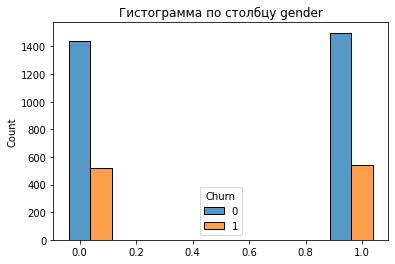

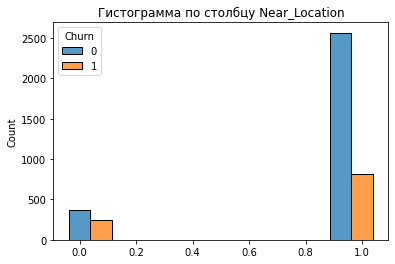

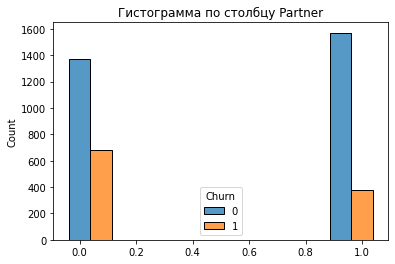

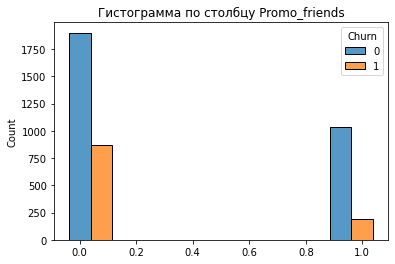

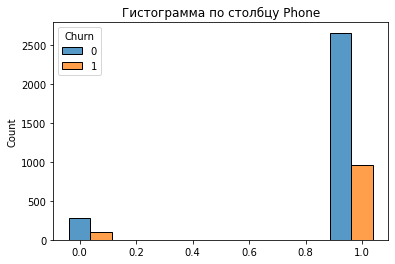

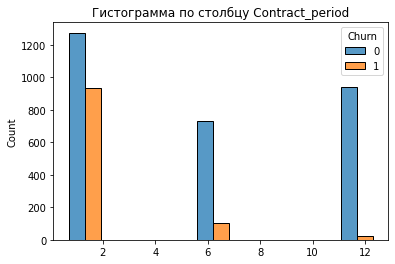

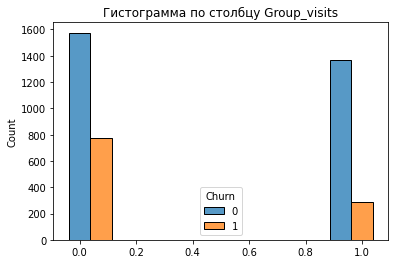

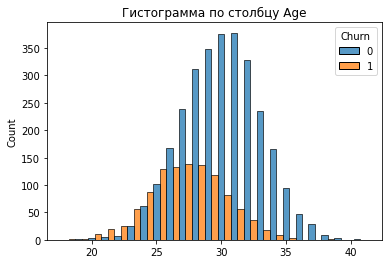

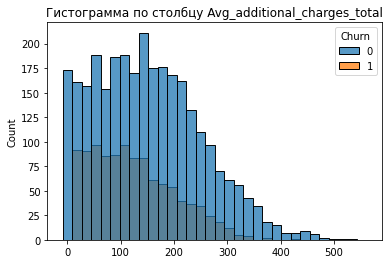

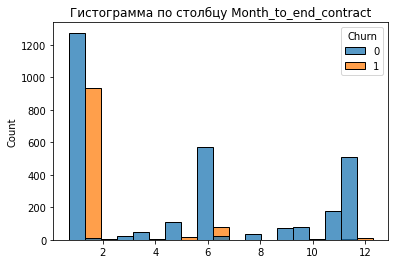

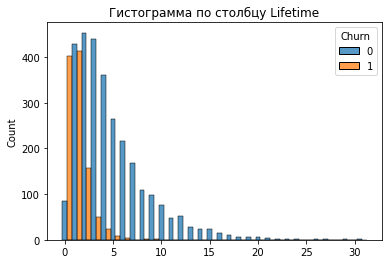

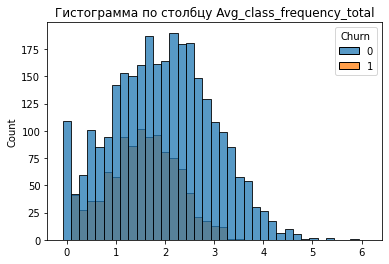

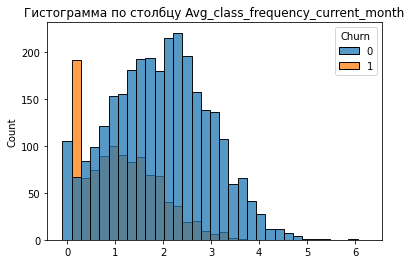

In [8]:
# построим гистограммы для всех признаков в цикле
for i in data.columns[:13]: # возьмем все колонки кроме колонки с целевой переменной
    plt.figure()
    sns.histplot(data = data, x=i, hue='Churn', multiple="dodge", shrink=2)
    plt.title('Гистограмма по столбцу ' + i)
    plt.xlabel('');


Из того, что бросается в глаза: 
- люди, воспользовавшиеся промоакцией "Приведи друга", а так же сотрудники компаний-клиентов утекают почти в 2 раза реже;
- из тех кто остался в 2 раза больше клиентов посещало групповые занятия, чем из тех кто ушел;
- люди, покупающие абонемент не больший срок не покидают клуб;
- оставшиеся люди тратят в полтора раза больше денег на доп услуги клуба;
- ну и тоже довольно очевидно, люди уходят ближе к концу абонемента, и мало кто, когда у него еще 5 месяцев оплаченных занятий;
- можно зафиксировать выброс в виде людей, которые купили абонемент, но вообще не посещают занятия.

### Матрица корреляций

Чтобы понять, какие из данных можно взять за признаки, влияющие на отток, построим матрицу корреляций.

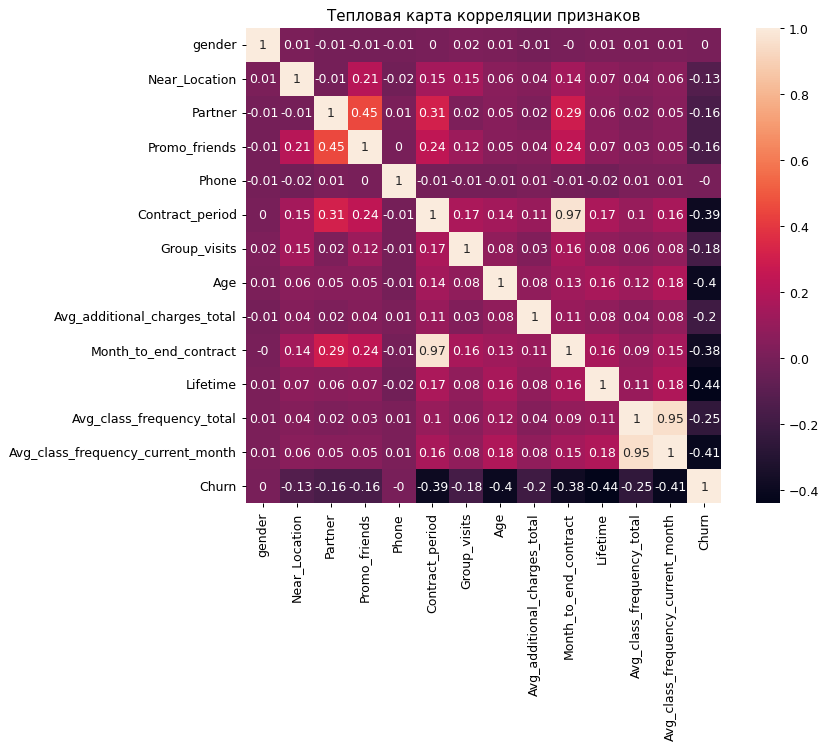

In [9]:
churn = round(data.corr(), 2)

fig, ax = plt.subplots(figsize=(10, 7), dpi=90)

# нарисуем тепловую карту с подписями для матрицы корреляций
ax = sns.heatmap(churn, annot=True, square=True)
plt.title('Тепловая карта корреляции признаков');


На тепловой карте видны сильно коррелирующие друг с другом признаки, это "Количество месяцев до конца абонемента" и "Длительности абонемента", а так же "Среднее число посещений в текущем месяце" и "Среднее посещение вообще". Чтобы не получить искажений в нашей модели следует удалить по 1 из признаков.

In [10]:
display(data.shape)
# удалим колонки
data = data.drop(columns=['Month_to_end_contract','Avg_class_frequency_total']).reset_index(drop=True) 
data.shape # проверим размерность 


(4000, 14)

(4000, 12)

[Содержание](#0)

##  Модель прогнозирования оттока клиентов
<a id=3> </a>


Для построения модели выберем признаки, корреляция которых с целевой переменной наибольшая. Тк в нашем случае 0 - означает, что клиент не ушел, а остался, мы будем смотреть на наибльшую отрицательную корреляцию, а это:
- Lifetime - как долго клиент с нами
- Avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц
- Contract_period - срок абонемента
- Age - возраст



Для моделирования воспользуемся линейной регрессией. 
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Соберем в отдельный датасет признаки и целевую переменную.

In [11]:
# выберем колонки с интересующими нас признаками
data_test = data[['Lifetime', 'Avg_class_frequency_current_month', 'Contract_period', 'Age', 'Churn']]
data_test


,Lifetime,Avg_class_frequency_current_month,Contract_period,Age,Churn
0,3,0.000000,6,29,0
1,7,1.910244,12,31,0
2,2,1.736502,1,28,0
3,2,3.357215,12,33,0
4,3,1.120078,1,26,0
...,...,...,...,...,...
3995,8,2.349070,12,33,0
3996,1,0.292859,1,29,1
3997,2,2.831439,12,28,0
3998,3,1.596237,6,32,0


In [12]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data_test.drop(columns=['Churn']) 
y = data_test['Churn']

#разделяем модель на обучающую и валидационную выборки в соотношении 80% к 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit(X_train) #обучаем scaler

#применяем стандартизацию к матрице признаков для тестовой выборки
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


Наша модель готова к обучению.

Т.к. мы прогнозируем одну конкретную величину - уйдет клиент или останется -, нам подойдет  алгоритм логистической регрессии.
.

### Обучение модели. Логистическая регрессия

In [13]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title=''):
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    print('Предсказанный моделью отток: {}'.format(predictions.sum()))

In [14]:
# определим модель, установим параметр random_state, чтобы можно было восстановить лгоритм при перезапуске; 
model = LogisticRegression(random_state = 0, solver = 'liblinear')
# обучим модель
model.fit(X_train_st, y_train)
# сделаем предсказание
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]
    
# проверим насколько точно работает наша модель
print_all_metrics(
    y_test, predictions, probabilities,
    title='Метрики модели логистической регрессии:'
)


Метрики модели логистической регрессии:
Accuracy: 0.90
Precision: 0.80
Recall: 0.80
F1: 0.80
ROC_AUC: 0.96
Предсказанный моделью отток: 199


### Обучение модели. Рандомный лес

In [15]:
# определим модель
model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель
model.fit(X_train_st, y_train)
# сделаем предсказание
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

# проверим насколько точно работает наша модель
print_all_metrics(
    y_test, predictions, probabilities,
    title='Метрики модели рандомного леса:'
)


Метрики модели рандомного леса:
Accuracy: 0.90
Precision: 0.79
Recall: 0.79
F1: 0.79
ROC_AUC: 0.95
Предсказанный моделью отток: 198


В общем обе модели неплохо делают свое дело, но логистическая регрессия чуть лучше.

[Содержание](#0)

## Кластеризация клиентов
<a id=4> </a>

Попробуем применить аглоритмы машинного обучения для кластеризации клиентов фитнес-клуба. Это поможет нам в будещем отнести новых клиентов к какой-либо группе и знать заранее, как долго они останутся с нами. 


### Дендрограмма

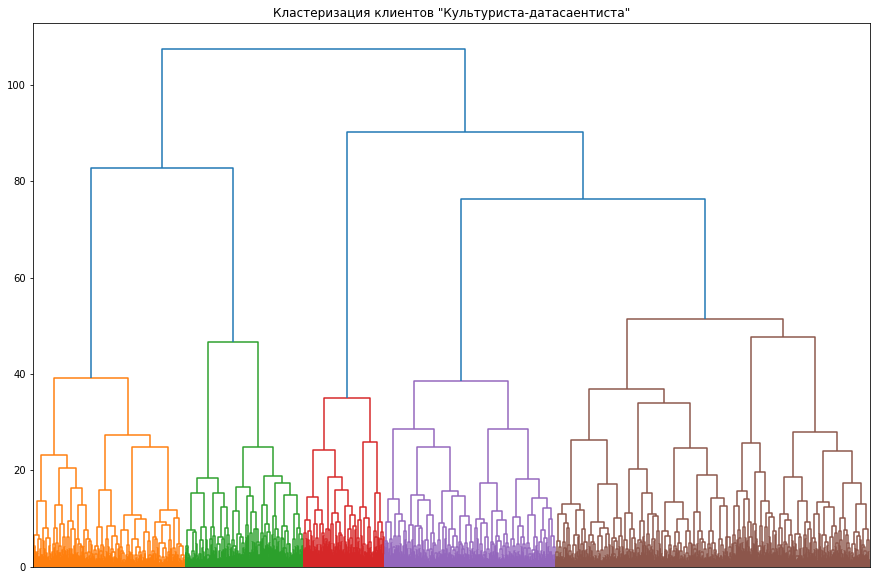

In [16]:
# стандартизируем данные
sc = StandardScaler()
data_sc = sc.fit_transform(data)

# передадим старндартизированную таблицу в качестве параметра функции linkage()
linked = linkage(data_sc, method = 'ward')

# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Кластеризация клиентов "Культуриста-датасаентиста"')
plt.show() 

Дендрограмма показывает на вероятное разделение на кластеры - их 5. А метод k-средних, который мы будем применять для кластеризации, предполагает что мы должны указать количество кластеров заранее. 

### Алгоритм K-Means и прогноз кластеров

In [17]:
# стандартизируем данные
sc = StandardScaler()
data_sc = sc.fit_transform(data)

km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(data_sc) # применяем алгоритм к данным и формируем вектор кластеров
data['cluster'] = labels # запишем метки кластера в наш датасет

data_clusters = data.groupby('cluster').mean()
np.transpose(round(data_clusters, 3)) # перевернем наш датасет для удобства


cluster,0,1,2,3,4
gender,0.501,0.516,0.523,0.501,0.514
Near_Location,0.000,0.999,0.863,0.992,1.000
Partner,0.487,0.216,0.472,0.936,0.336
Promo_friends,0.074,0.055,0.306,0.810,0.225
Phone,1.000,1.000,0.000,1.000,1.000
Contract_period,2.989,3.871,4.777,8.633,1.740
Group_visits,0.237,0.460,0.427,0.527,0.290
Age,28.700,30.053,29.298,29.927,26.903
Avg_additional_charges_total,137.061,160.909,144.208,158.816,114.387
Lifetime,2.987,4.747,3.940,4.702,0.978


Самые удачные для нас кластеры 2 и 3 - в их почти никто не ушел. Самый неудачный кластер - 4, там почти 100% вероятность ухода клиента.

### Визуализация кластеров

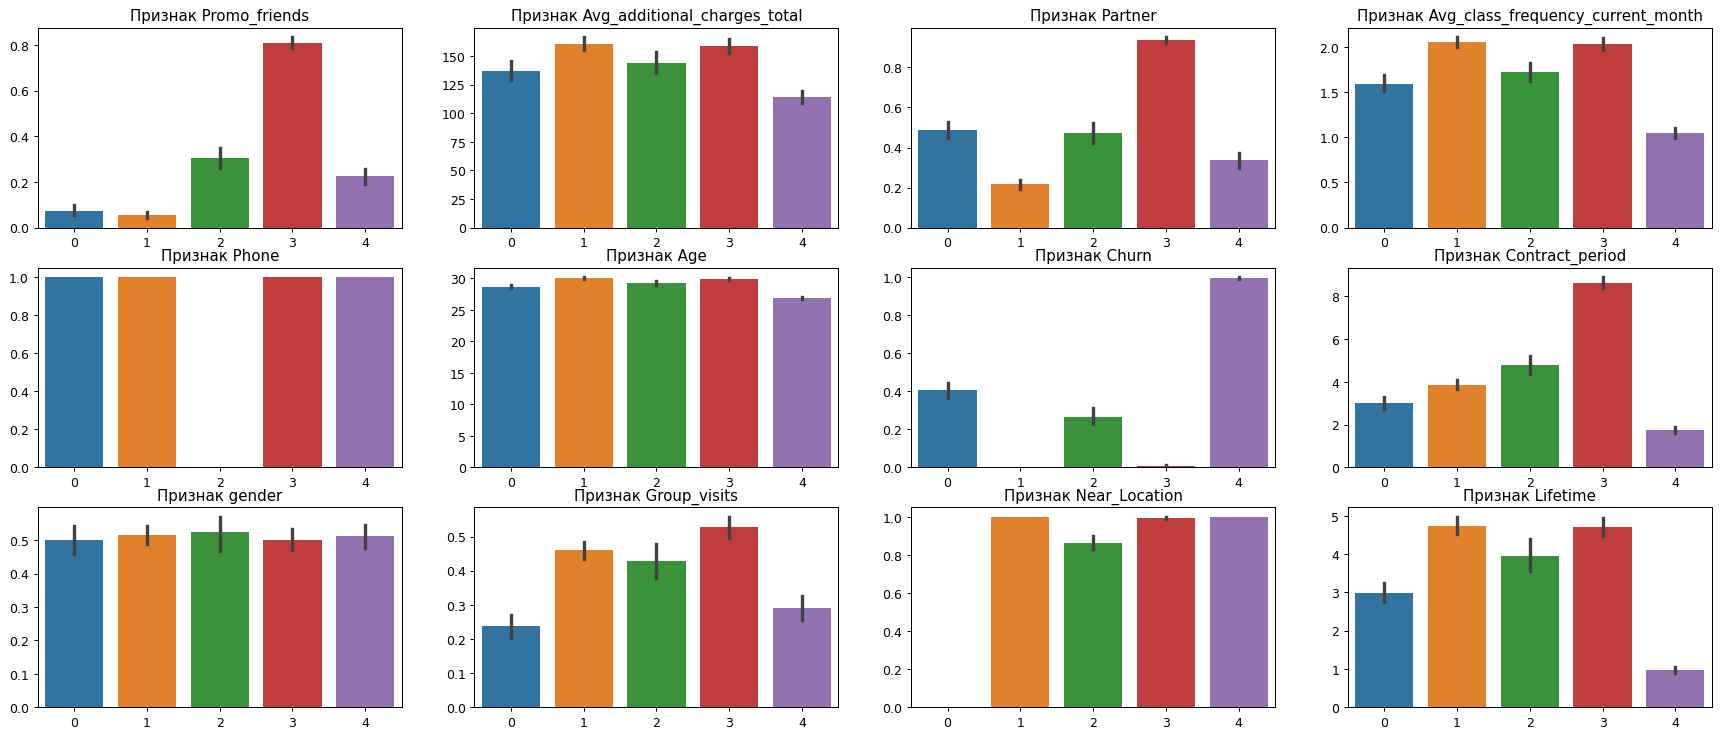

In [18]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам

f, axes = plt.subplots(nrows=3, ncols=4, figsize=(24,10), dpi=90)
features = list(set(data.columns[:-1])) # соберем список нужных признаков
for idx, feat in  enumerate(features): # в цикле переберем все графики
    sns.barplot(y=feat, x='cluster', data=data, ax=axes[idx // 4, idx % 4]).set(title='Признак ' + feat)
    axes[idx // 4, idx % 4].set_ylabel('')
    axes[idx // 4, idx % 4].set_xlabel('');
         




На самом деле визуализация показывает нам, что по факту делить достаточно на 3 группы.
Какие выводы можно сделать.
- Пол большой роли не играет.
- Промо-акция "Приведи друга", а так же партнерские программы помогают удерживать клиентов.
- Люди, покупающие абонемент на большой срок, с большей вероятностью остаются клиетами студии, и наоборот - если срок абонемента маленький, скорее всего такой клиент с нами не надолго.
- Оставшиеся клиента с бОльшей вероятностью посещают групповые занятия.
- Возраст не играет большой роли, но у клиентов фитне-центра в принципе не слишком большой возрастной разброс.
- Оставшиеся с большей охотой тратят деньги на дополнительные услуги центра.
- Если человек не оставил свой номер телефона, он уйдет с вероятностью 25%.
- Чем дольше человек является клиентом студии, тем меньше вероятность оттока. В 4 кластере очень мало 'долгожителей'.
- Если клиент посещал много занятий в прошлом месяце, скорее всего он останется с нами.

[Содержание](#0)

## Вывод
<a id=5> </a>

Мы провели исследование данных клиентов фитнес-клуба `Культурист-датасаентист` и смогли сделать прогноз оттока клиентов и отыскать признаки, на которые сотрудники центра могут обращать внимание для того, чтобы снизить отток и помочь новым клиентам стать постоянными и остаться ими на долгое время.

Что нам удалось выяснить? 

Промо-акции и привлечение корпоративных клиентов помогают удержанию.  
По-возможности, следут продавать абонементы на более длительный срок. Хотя бывает сложно понять, посещает ли купивший абонемент человек занятия или спортивная форма просто лежит у него на полке для успокоения совести? Возможно следует делать обзвон или смс-рассылку клиентам, которые более 3 недель не посещали занятия, так можно еще и узнать информацию, ушел ли клиент или еще планирует продолжать.  
Вытекающее из предыдущего: лучше просить людей оставлять свой номер телефона.  
Стимулировать на приобретение доп услуг: возможно клиенту так понравится наш смуззи-бар, что он потеряет покой.
Групповые занятия так же важны, людям, тягающим штангу нужен стречинг, офисному планктону нравится заниматься йогой.

Надеемся эти рекомендации помогут снизить отток клиентов и сделать его более контролируемым.
